# **Análise das avaliações em geral**

Uma análise detalhada em cima das avaliações dos clientes pode trazer diversos insights, como: principais pontos valorizados pelos clientes, problemas nos processos de vendas, palavras-chave de grupos de avaliações, entre outros.

**Observação: Optei por deixar apenas uma avaliação por pedido, pois há casos onde o id do pedido e da avaliação se repetem.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import metrics
from wordcloud import WordCloud

#### **Importação e análise**

In [2]:
produtos = pd.read_csv('../bases_de_dados/bases_trabalhadas/products_1.csv')
vendas = pd.read_csv('../bases_de_dados/bases_trabalhadas/orders_1_.csv', low_memory=False)
avaliacoes = pd.read_csv('../bases_de_dados/bases_trabalhadas/pedidos_e_avaliacoes.csv', low_memory=False)
itens_vendas = pd.read_csv('../bases_de_dados/bases_trabalhadas/order_items_1.csv')
vendedores = pd.read_csv('../bases_de_dados/bases_trabalhadas/sellers_1.csv')

In [3]:
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaN,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday


#### **Transformando colunas em tipo data**

In [4]:
col_datas = ['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']
for i in col_datas:
    vendas[i] = pd.to_datetime(vendas[i], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Analisando o tipo das colunas após as mudanças
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        99441 non-null  object        
 1   customer_id                     99441 non-null  object        
 2   order_status                    99441 non-null  object        
 3   order_purchase_timestamp        99441 non-null  datetime64[ns]
 4   order_delivered_carrier_date    97658 non-null  object        
 5   order_delivered_customer_date   96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date   99441 non-null  datetime64[ns]
 7   review_id                       98673 non-null  object        
 8   review_score                    98673 non-null  float64       
 9   review_comment_title            99441 non-null  object        
 10  review_comment_message          99441 non-null  object        
 11  re

In [6]:
# Informações da base de avaliações
avaliacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98095 entries, 0 to 98094
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review_id                       98095 non-null  object 
 1   order_id                        98095 non-null  object 
 2   review_score                    98095 non-null  int64  
 3   review_comment_title            11509 non-null  object 
 4   review_comment_message          40554 non-null  object 
 5   review_creation_date            98095 non-null  object 
 6   review_answer_timestamp         98095 non-null  object 
 7   order_purchase_timestamp        98095 non-null  object 
 8   order_delivered_customer_date   95299 non-null  object 
 9   order_estimated_delivery_date   98095 non-null  object 
 10  diferenca_estimativa_e_entrega  95299 non-null  float64
 11  dia_compra                      98095 non-null  int64  
 12  mes_compra                      

#### **Nomeando os valores nulos das mensagens e titulos de avaliações**

In [7]:
avaliacoes.loc[avaliacoes.review_comment_title.isnull(), 'review_comment_title'] = 'sem_titulo'
avaliacoes.loc[avaliacoes.review_comment_message.isnull(), 'review_comment_message'] = 'sem_comentarios'

In [8]:
# Informações da base de produtos
produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  object 
 3   product_description_lenght  32951 non-null  object 
 4   product_photos_qty          32951 non-null  object 
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.3+ MB


# **1. Avaliações**

In [9]:
# Valores únicos por coluna
avaliacoes.nunique()

review_id                         98095
order_id                          98095
review_score                          5
review_comment_title               4526
review_comment_message            36061
review_creation_date                756
review_answer_timestamp           97933
order_purchase_timestamp          97729
order_delivered_customer_date     94500
order_estimated_delivery_date       459
diferenca_estimativa_e_entrega      196
dia_compra                           31
mes_compra                           12
ano_compra                            3
hora_compra                          24
dtype: int64

#### **Criando bases das notas (1,2,3,4,5) separadamente**

In [10]:
nota1 = avaliacoes.loc[avaliacoes.review_score == 1]
nota2 = avaliacoes.loc[avaliacoes.review_score == 2]
nota3 = avaliacoes.loc[avaliacoes.review_score == 3]
nota4 = avaliacoes.loc[avaliacoes.review_score == 4]
nota5 = avaliacoes.loc[avaliacoes.review_score == 5]

In [11]:
# Quantidade de avaliações por nota
avaliacoes.review_score.value_counts().sort_index()

1    11247
2     3103
3     8073
4    18951
5    56721
Name: review_score, dtype: int64

#### **Criando função para exibir as nuvens de palavras**

In [12]:
def exibir_nuvens(nota, wordcloud1, wordcloud2):
    fig, ax = plt.subplots(nrows=2, figsize=(9,8))
    ax[0].imshow(wordcloud1, interpolation = 'bilinear')
    ax[0].axis('off')

    ax[1].imshow(wordcloud2, interpolation = 'bilinear')
    ax[1].axis('off')

    ax[0].set_title('Palavras', fontweight='bold',fontsize=14)
    ax[1].set_title('Frases', fontweight='bold',fontsize=14)

    plt.suptitle(f'NUVEM DE PALAVRAS - {nota}', fontweight='bold', color='black', fontsize=18)
    plt.savefig(f"../imagens/{nota}_nuvens.png")
    plt.show()

In [13]:
# Definindo palavras para não aparecer na nuvem de palavras
palavras_nao_aparecer = ['a','e','que','de','o','em','para','meu','com','do','da','até','era','tarde','noite','dia','boatarde','bomdia','boanoite', 'Boatarde','Bomdia','Boanoite']

### **Nota 1:**

In [14]:
comentarios_nota1_palavras = ''
for i in nota1.loc[(nota1.order_id.notnull()) & (nota1.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota1_palavras += i
    comentarios_nota1_palavras += '  '
wordcloud_1_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota1_palavras)

comentarios_nota1_frases = ''
for i in nota1.loc[(nota1.order_id.notnull()) & (nota1.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota1_frases += i
    comentarios_nota1_frases += '  '
wordcloud_1_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota1_frases)

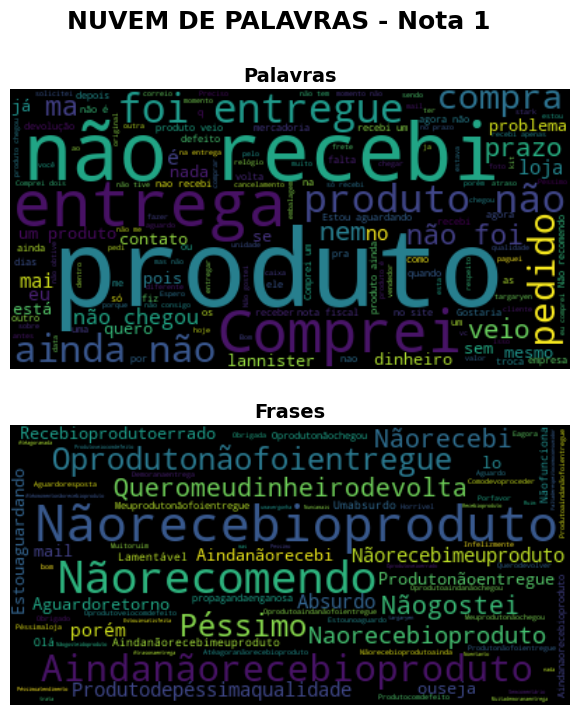

In [15]:
exibir_nuvens('Nota 1', wordcloud_1_1, wordcloud_1_2)

#### **Nota 1 - Conclusão:**

Na nuvem de palavras e frases podemos notar que há uma grande quantidade de reclamações envolvendo o não recebimento do produto, devido a possíveis atrasos nas entregas. Além disso, frases como "Quero meu dinheiro de volta" e Produto de péssima qualidade" também se destacam.

### **Nota 2:**

In [16]:
comentarios_nota2_palavras = ''
for i in nota2.loc[(nota2.order_id.notnull()) & (nota2.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota2_palavras += i
    comentarios_nota2_palavras += '  '
wordcloud_2_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota2_palavras)

comentarios_nota2_frases = ''
for i in nota2.loc[(nota2.order_id.notnull()) & (nota2.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota2_frases += i
    comentarios_nota2_frases += '  '
wordcloud_2_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota2_frases)

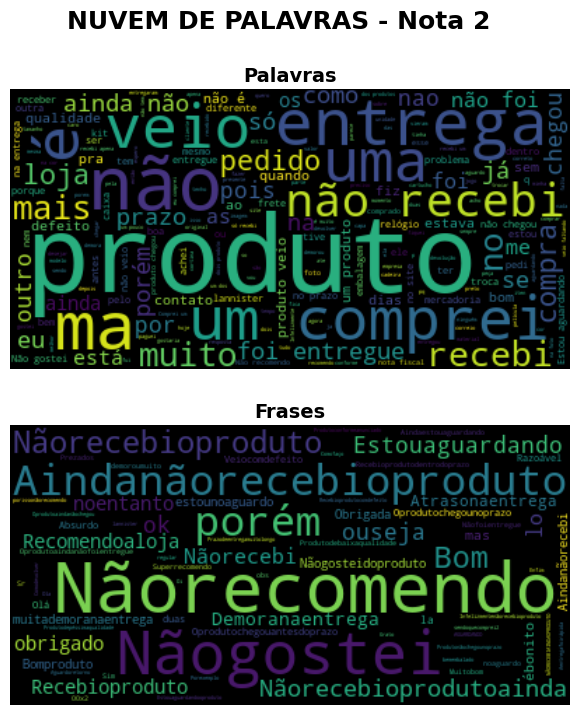

In [17]:
exibir_nuvens('Nota 2', wordcloud_2_1, wordcloud_2_2)

#### **Nota 2 - Conclusão:**

Como nas avaliações de nota 1, reclamações referentes a atraso na entrega também são frequentes, porém, com menor intensidade, como podemos ver nas nuvens. Relatos como: "Não gostei do produto" e "Não recomendo" também se destacam.

### **Nota 3:**

In [18]:
comentarios_nota3_palavras = ''
for i in nota3.loc[(nota3.order_id.notnull()) & (nota3.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota3_palavras += i
    comentarios_nota3_palavras += '  '
wordcloud_3_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota3_palavras)

comentarios_nota3_frases = ''
for i in nota3.loc[(nota3.order_id.notnull()) & (nota3.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota3_frases += i
    comentarios_nota3_frases += '  '
wordcloud_3_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota3_frases)

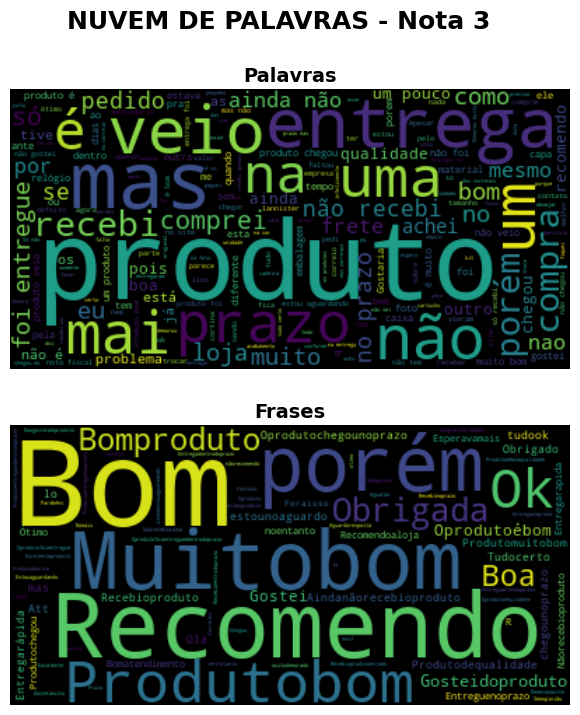

In [19]:
exibir_nuvens("Nota 3", wordcloud_3_1, wordcloud_3_2)

#### **Nota 3 - Conclusão**

Sendo uma nota próxima a uma avaliação média, a nuvem de palavras ja muda com maior notoriedade. Na nuvem de frases vemos relatos como: "Bom", "Muito bom" e "Recomendo". Mas, devemos ficar de olho em palavras como "porém" que aparece com uma certa frequencia.

### **Nota 4:**

In [20]:
comentarios_nota4_palavras = ''
for i in nota4.loc[(nota4.order_id.notnull()) & (nota4.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota4_palavras += i
    comentarios_nota4_palavras += '  '
wordcloud_4_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota4_palavras)

comentarios_nota4_frases = ''
for i in nota4.loc[(nota4.order_id.notnull()) & (nota4.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota4_frases += i
    comentarios_nota4_frases += '  '
wordcloud_4_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota4_frases)

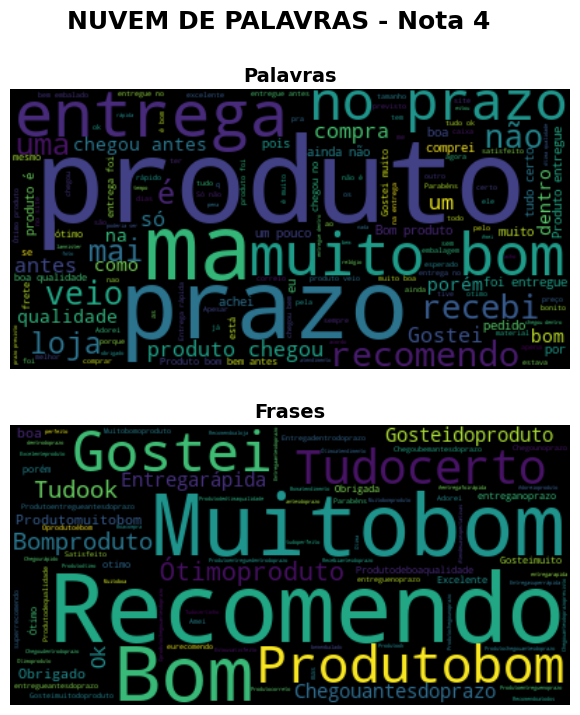

In [21]:
exibir_nuvens("Nota 4", wordcloud_4_1, wordcloud_4_2)

#### **Nota 4 - Conclusão**

Aqui o cenário já muda completamente, onde palavras e frases positivas são mais recorrentes, exemplo: "Recomendo", "Muito bom", "Ótimo produto", "Tudo certo" e "Chegou antes do prazo". Devemos ficar de olho em frases como "Entrega rápida" e "Chegou antes do prazo", seria uma correlação positiva de entrega antecipada com o valor da nota?

### **Nota 5:**

In [22]:
comentarios_nota5_palavras = ''
for i in nota5.loc[(nota5.order_id.notnull()) & (nota5.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota5_palavras += i
    comentarios_nota5_palavras += '  '
wordcloud_5_1 = WordCloud(stopwords=['a','e','que','de','o']).generate(comentarios_nota5_palavras)

comentarios_nota5_frases = ''
for i in nota5.loc[(nota5.order_id.notnull()) & (nota5.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota5_frases += i
    comentarios_nota5_frases += '  '
wordcloud_5_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota5_frases)

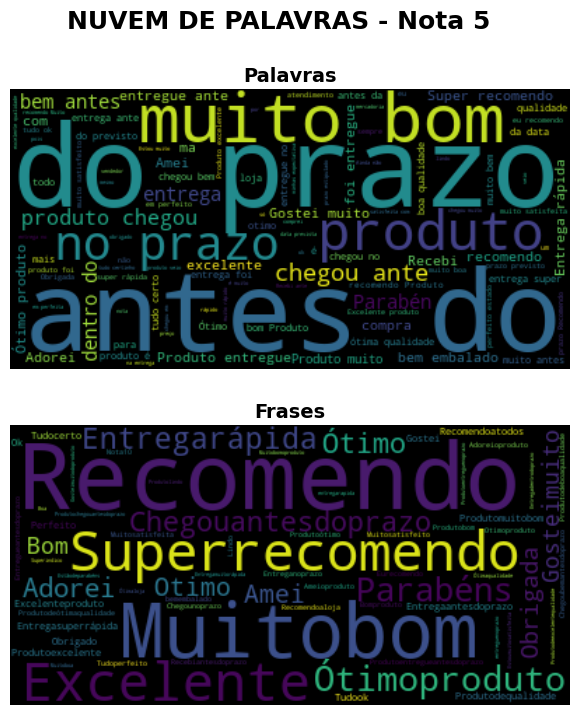

In [23]:
exibir_nuvens("Nota 5", wordcloud_5_1, wordcloud_5_2)

#### **Nota 5 - Conclusão**

Nessas nuvens relatos referentes a entrega antes do prazo aparecem ainda mais. Palavras e frases com elogios ao produto se destacam nas nuvens 

#### **Observação geral:**
- As ocorrências de avaliações baixas possuem diversos motivos, como: atraso na entrega, produto de má qualidade, problemas com o funcionamento do produto, mal atendimento, entre outros. Portanto, apesar do atraso ser bem frequente nas avaliações de nota 1, é importante não generalizarmos, pois possuem outras causas.

# **2. Atraso**

In [24]:
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaT,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday


In [25]:
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        99441 non-null  object        
 1   customer_id                     99441 non-null  object        
 2   order_status                    99441 non-null  object        
 3   order_purchase_timestamp        99441 non-null  datetime64[ns]
 4   order_delivered_carrier_date    97658 non-null  object        
 5   order_delivered_customer_date   96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date   99441 non-null  datetime64[ns]
 7   review_id                       98673 non-null  object        
 8   review_score                    98673 non-null  float64       
 9   review_comment_title            99441 non-null  object        
 10  review_comment_message          99441 non-null  object        
 11  re

In [26]:
# Valores nulos na coluna referente a diferença da data de estimativa de entrega com a da data de entrega
vendas.diferenca_estimativa_e_entrega.isnull().sum()

2965

**Obs: Esses 2965 valores foram de produtos ainda não entregues, como vimos no notebook "01 - Primeiras limpezas e insights"**

#### **Criando uma coluna target de atraso, com valores 0 e 1**

In [27]:
vendas['atraso'] = vendas.diferenca_estimativa_e_entrega.apply(lambda x:1 if x < 0 else 0)
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra,atraso
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday,1
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaT,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday,0
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday,0


In [28]:
# Analisando quantidade de valores por classe
vendas['atraso'].value_counts()

0    91614
1     7827
Name: atraso, dtype: int64

In [29]:
# Juntando infomações de bases diferentes
avaliacoes = pd.merge(avaliacoes, vendas[['order_id','atraso']], on='order_id',how='inner')

In [30]:
# Analisando valores nulos
avaliacoes.isnull().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title                 0
review_comment_message               0
review_creation_date                 0
review_answer_timestamp              0
order_purchase_timestamp             0
order_delivered_customer_date     2796
order_estimated_delivery_date        0
diferenca_estimativa_e_entrega    2796
dia_compra                           0
mes_compra                           0
ano_compra                           0
hora_compra                          0
atraso                               0
dtype: int64

In [31]:
avaliacoes.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,atraso
0,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-37.0,15,9,2016,12,1
1,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,2016-10-22 08:25:27,NaN,2016-10-24,NaN,22,10,2016,8,0
2,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-06 20:06:26,2016-10-15 11:00:25,2016-11-28,43.0,6,10,2016,20,0


In [32]:
# Visualizando a média das notas de acordo com a classes de atrasos (0 e 1)
avaliacoes.groupby('atraso')['review_score'].mean()

atraso
0    4.216918
1    2.566968
Name: review_score, dtype: float64

**Operação inversa**

In [33]:
avaliacoes.groupby('review_score')['atraso'].value_counts()

review_score  atraso
1             0          7729
              1          3518
2             0          2504
              1           599
3             0          7205
              1           868
4             0         18009
              1           942
5             0         55025
              1          1696
Name: atraso, dtype: int64

#### **Criando uma visualização das quantidades de avaliações e atrasos**

In [34]:
nota1 = avaliacoes.loc[avaliacoes.review_score == 1]
nota2 = avaliacoes.loc[avaliacoes.review_score == 2]
nota3 = avaliacoes.loc[avaliacoes.review_score == 3]
nota4 = avaliacoes.loc[avaliacoes.review_score == 4]
nota5 = avaliacoes.loc[avaliacoes.review_score == 5]

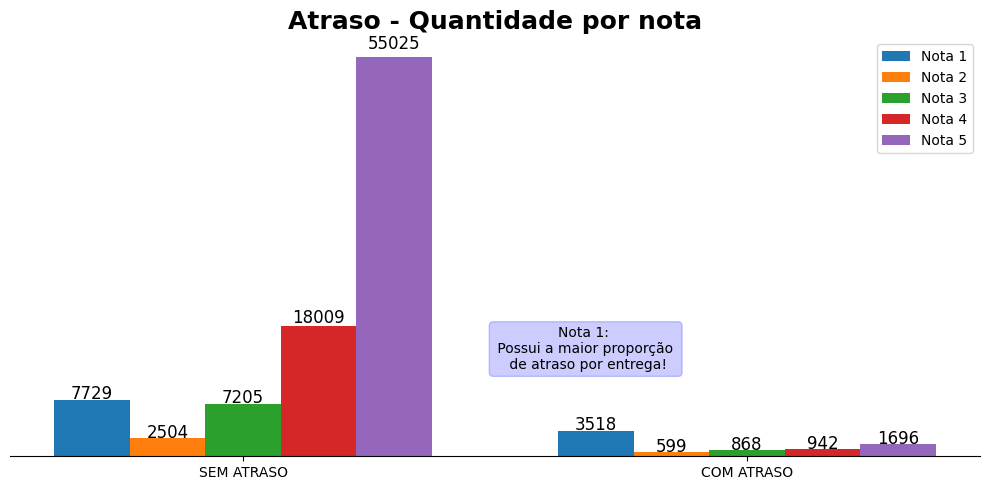

In [35]:
a = nota1.atraso.value_counts()
b = nota2.atraso.value_counts()
c = nota3.atraso.value_counts()
d = nota4.atraso.value_counts()
e = nota5.atraso.value_counts()

w=0.15
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
ax.bar(a.index-w*2, a.values, width=w, label='Nota 1')
ax.bar(b.index-w, b.values, width=w, label='Nota 2')
ax.bar(c.index, c.values, width=w, label='Nota 3')
ax.bar(d.index+w, d.values, width=w, label='Nota 4')
ax.bar(e.index+w*2, e.values, width=w, label='Nota 5')
ax.legend()
ax.set_xticks([0,1])
ax.set_xticklabels(['SEM ATRASO', 'COM ATRASO'])
ax.spines[['top','left','right']].set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Atraso - Quantidade por nota', fontweight='bold', fontsize=18)

for i in range(2):
    ax.annotate(a.values[i], (a.index[i]-w*2, a.values[i]+a.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(b.values[i], (b.index[i]-w, b.values[i]+b.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(c.values[i], (c.index[i], c.values[i]+c.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(d.values[i], (d.index[i]+w, d.values[i]+d.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(e.values[i], (e.index[i]+w*2, e.values[i]+e.values[i]*0.02), ha='center', fontsize=12)
    
ax.text(0.68, 12000, 'Nota 1: \n Possui a maior proporção \n de atraso por entrega!', ha='center', bbox=dict(facecolor='blue', edgecolor='blue', boxstyle='round,pad=0.3', alpha=0.2))
    
plt.savefig('../imagens/atraso_qtd_nota.png', transparent=True)
plt.show()

Como podemos ver acima, **grande porcentagem das avaliações nota 1 houveram atraso**. Quando comparamos percentualmente as proporções com as outras notas, vemos que possivelmente há uma correlação entre a nota 1 e a classe de atraso.

### **Analisando a correlação entre a nota e o atraso**

In [36]:
correlacoes = avaliacoes[['review_score','atraso']].copy()
correlacoes.head(3)

,review_score,atraso
0,1,1
1,1,0
2,4,0


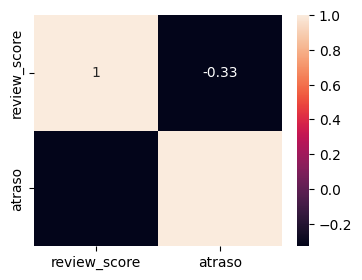

In [37]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(correlacoes.corr(), annot=True, ax=ax)
plt.show()

Analisando o mapa de calor acima, vemos que há uma correlação negativa entre a nota e o atraso.

#### **Analisando as informações que conseguimos neste notebook, abrimos portas para explorar alguns assuntos**

- Variação da média das notas de acordo com dias de atraso
- Categorias de produtos com mais atrasos e más avaliações
- Há vendedores com quantidades anormais de atrasos ou produtos de má qualidade?

In [38]:
avaliacoes.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,atraso
0,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-37.0,15,9,2016,12,1
1,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,2016-10-22 08:25:27,NaN,2016-10-24,NaN,22,10,2016,8,0
2,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-06 20:06:26,2016-10-15 11:00:25,2016-11-28,43.0,6,10,2016,20,0


In [39]:
itens_vendas = pd.read_csv('../bases_de_dados/bases_trabalhadas/order_items_1.csv')
vendedores = pd.read_csv('../bases_de_dados/bases_trabalhadas/sellers_1.csv')

In [40]:
itens_vendas.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff


In [41]:
avaliacoes1 = avaliacoes.copy()
avaliacoes1 = pd.merge(avaliacoes1, itens_vendas[['order_id','seller_id','product_category_name']],
                       on='order_id', how='left')

In [42]:
avaliacoes1.isnull().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title                 0
review_comment_message               0
review_creation_date                 0
review_answer_timestamp              0
order_purchase_timestamp             0
order_delivered_customer_date     2796
order_estimated_delivery_date        0
diferenca_estimativa_e_entrega    2796
dia_compra                           0
mes_compra                           0
ano_compra                           0
hora_compra                          0
atraso                               0
seller_id                          723
product_category_name             2125
dtype: int64

In [43]:
avaliacoes1.product_category_name.value_counts().head(10)

cama_mesa_banho           9125
beleza_saude              8692
esporte_lazer             7573
informatica_acessorios    6574
moveis_decoracao          6217
utilidades_domesticas     5767
relogios_presentes        5548
telefonia                 4154
automotivo                3838
brinquedos                3814
Name: product_category_name, dtype: int64

In [44]:
avaliacoes_atraso = avaliacoes1.loc[avaliacoes1.atraso == 1]
avaliacoes_atraso['product_category_name'].value_counts().head(10)

cama_mesa_banho           772
beleza_saude              756
esporte_lazer             569
moveis_decoracao          520
informatica_acessorios    489
relogios_presentes        455
utilidades_domesticas     390
telefonia                 345
automotivo                322
brinquedos                272
Name: product_category_name, dtype: int64

Aparentemente a quantidade de entregas com atrasos segue quase a mesma ordenação das entregas totais, como podemos ver acima.

In [45]:
avaliacoes_atraso.seller_id.value_counts().head(10)

4a3ca9315b744ce9f8e9374361493884    188
1f50f920176fa81dab994f9023523100    145
4869f7a5dfa277a7dca6462dcf3b52b2    128
ea8482cd71df3c1969d7b9473ff13abc    117
6560211a19b47992c3666cc44a7e94c0    114
cc419e0650a3c5ba77189a1882b7556a    100
955fee9216a65b617aa5c0531780ce60     96
8b321bb669392f5163d04c59e235e066     96
7c67e1448b00f6e969d365cea6b010ab     95
da8622b14eb17ae2831f4ac5b9dab84a     94
Name: seller_id, dtype: int64

Para facilitar a visualização, anteriormente atribui valores de 1 até o len(qtd_vendedores), para melhor entendimento.

In [46]:
avaliacoes1 = pd.merge(avaliacoes1, vendedores[['seller_id','seller_id_num']],
                       on='seller_id', how='left')

In [47]:
avaliacoes_atraso = avaliacoes1.loc[avaliacoes1.atraso == 1]

#### **Vendedores com mais atrasos nas entregas**

In [48]:
avaliacoes_atraso.seller_id_num.value_counts().head(10)

2463.0    188
474.0     145
2617.0    128
987.0     117
797.0     114
1413.0    100
390.0      96
332.0      96
1182.0     95
1873.0     94
Name: seller_id_num, dtype: int64

#### **Vendedores com mais avaliações de nota 1 (em números)**

In [49]:
avaliacoes1.loc[avaliacoes1.review_score == 1, 'seller_id_num'].value_counts().head(10)

2463.0    239
797.0     221
1413.0    197
1182.0    192
474.0     147
987.0     128
2617.0    115
2720.0    113
332.0     108
390.0     106
Name: seller_id_num, dtype: int64

#### **Vendedores com mais avaliações nota 5 (em números)**

In [50]:
avaliacoes1.loc[avaliacoes1.review_score == 5, 'seller_id_num'].value_counts().head(10)

1413.0    972
797.0     933
2463.0    841
474.0     835
1873.0    751
390.0     716
2207.0    708
2617.0    670
987.0     600
2345.0    600
Name: seller_id_num, dtype: int64

- pegar o total de avaliações
- pegar o total por nota

### **Criando uma base com a quantidade de avaliações por vendedores, além dos percentuais das notas comparados ao total de avaliações**

#### **Criando bases separadas com as notas**

In [51]:
vendedores_notas5 = avaliacoes1.loc[avaliacoes1.review_score == 5, 'seller_id_num'].value_counts().sort_index().reset_index()
vendedores_notas5.columns = ['seller_id_num', 'Nota 5']
vendedores_notas4 = avaliacoes1.loc[avaliacoes1.review_score == 4, 'seller_id_num'].value_counts().sort_index().reset_index()
vendedores_notas4.columns = ['seller_id_num', 'Nota 4']
vendedores_notas3 = avaliacoes1.loc[avaliacoes1.review_score == 3, 'seller_id_num'].value_counts().sort_index().reset_index()
vendedores_notas3.columns = ['seller_id_num', 'Nota 3']
vendedores_notas2 = avaliacoes1.loc[avaliacoes1.review_score == 2, 'seller_id_num'].value_counts().sort_index().reset_index()
vendedores_notas2.columns = ['seller_id_num', 'Nota 2']
vendedores_notas1 = avaliacoes1.loc[avaliacoes1.review_score == 1, 'seller_id_num'].value_counts().sort_index().reset_index()
vendedores_notas1.columns = ['seller_id_num', 'Nota 1']

#### **Juntando as bases**

In [52]:
vendedores_notas = pd.merge(vendedores_notas5, vendedores_notas4, on='seller_id_num', how='outer')
vendedores_notas = pd.merge(vendedores_notas, vendedores_notas3, on='seller_id_num', how='outer')
vendedores_notas = pd.merge(vendedores_notas, vendedores_notas2, on='seller_id_num', how='outer')
vendedores_notas = pd.merge(vendedores_notas, vendedores_notas1, on='seller_id_num', how='outer')

#### **Pequenas alterações nos índices e tipos de colunas**

In [53]:
vendedores_notas = vendedores_notas.reset_index()
vendedores_notas = vendedores_notas.drop('index', axis=1)
vendedores_notas = vendedores_notas.fillna(0)
vendedores_notas = vendedores_notas.sort_values(by='seller_id_num')
vendedores_notas['seller_id_num'] = vendedores_notas['seller_id_num'].astype(int)
vendedores_notas['seller_id_num'] = vendedores_notas['seller_id_num'].astype(str)

#### **Criando coluna com o total de avaliaçõe por vendedor**

In [54]:
vendedores_notas['Total de avaliações'] = vendedores_notas['Nota 1'] + vendedores_notas['Nota 2'] + vendedores_notas['Nota 3'] + vendedores_notas['Nota 4'] + vendedores_notas['Nota 5']

#### **Renomeando as colunas**

In [55]:
vendedores_notas.columns = ['ID-Vendedor', 'Qtd Notas 5', 'Qtd Notas 4', 'Qtd Notas 3', 'Qtd Notas 2', 'Qtd Notas 1', 'Total de avaliações']
vendedores_notas = vendedores_notas.reset_index(drop=True)

#### **Mudando tipo das colunas de float para inteiro (para melhor visualização)**

In [56]:
vendedores_notas['Qtd Notas 5'] = vendedores_notas['Qtd Notas 5'].astype(int)
vendedores_notas['Qtd Notas 4'] = vendedores_notas['Qtd Notas 4'].astype(int)
vendedores_notas['Qtd Notas 3'] = vendedores_notas['Qtd Notas 3'].astype(int)
vendedores_notas['Qtd Notas 2'] = vendedores_notas['Qtd Notas 2'].astype(int)
vendedores_notas['Qtd Notas 1'] = vendedores_notas['Qtd Notas 1'].astype(int)
vendedores_notas['Total de avaliações'] = vendedores_notas['Total de avaliações'].astype(int)

#### **Criando colunas com as porcentagens das notas, quando comparadas com o total**

In [57]:
vendedores_notas['Nota 5 %'] = (round(((vendedores_notas['Qtd Notas 5'] / vendedores_notas['Total de avaliações']) * 100),2))
vendedores_notas['Nota 4 %'] = (round(((vendedores_notas['Qtd Notas 4'] / vendedores_notas['Total de avaliações']) * 100),2))
vendedores_notas['Nota 3 %'] = (round(((vendedores_notas['Qtd Notas 3'] / vendedores_notas['Total de avaliações']) * 100),2))
vendedores_notas['Nota 2 %'] = (round(((vendedores_notas['Qtd Notas 2'] / vendedores_notas['Total de avaliações']) * 100),2))
vendedores_notas['Nota 1 %'] = (round(((vendedores_notas['Qtd Notas 1'] / vendedores_notas['Total de avaliações']) * 100),2))

In [58]:
vendedores_notas

,ID-Vendedor,Qtd Notas 5,Qtd Notas 4,Qtd Notas 3,Qtd Notas 2,Qtd Notas 1,Total de avaliações,Nota 5 %,Nota 4 %,Nota 3 %,Nota 2 %,Nota 1 %
0,0,1,0,1,0,1,3,33.33,0.0,33.33,0.0,33.33
1,1,29,8,1,0,2,40,72.50,20.0,2.50,0.0,5.00
2,2,1,0,0,0,0,1,100.00,0.0,0.00,0.0,0.00
3,3,1,0,0,0,0,1,100.00,0.0,0.00,0.0,0.00
4,4,0,0,0,0,1,1,0.00,0.0,0.00,0.0,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3069,3090,2,0,0,0,0,2,100.00,0.0,0.00,0.0,0.00
3070,3091,5,3,1,0,1,10,50.00,30.0,10.00,0.0,10.00
3071,3092,6,0,0,0,0,6,100.00,0.0,0.00,0.0,0.00
3072,3093,4,3,0,1,0,8,50.00,37.5,0.00,12.5,0.00


#### **Pesquisando por vendedores com mais de 100 vendas e mais de 25% de avaliações nota 1**

In [59]:
vendedores_notas.loc[(vendedores_notas['Total de avaliações'] > 100) & (vendedores_notas['Nota 1 %'] > 25.00),
                     ['ID-Vendedor','Nota 1 %','Nota 2 %','Nota 3 %','Nota 4 %','Nota 5 %','Total de avaliações']]

,ID-Vendedor,Nota 1 %,Nota 2 %,Nota 3 %,Nota 4 %,Nota 5 %,Total de avaliações
1014,1019,25.21,5.88,8.40,18.49,42.02,119
1105,1111,40.40,9.60,13.64,12.63,23.74,198
1872,1881,28.57,3.76,9.02,19.55,39.10,133
1894,1903,25.43,3.45,9.91,19.40,41.81,232
2844,2863,53.57,8.04,10.71,7.14,20.54,112


**Acima podemos ver que há um vendedor com mais de 50% das avaliações como nota 1. Com um total de 112 vendas.**

#### **Retornando a lista de vendedores com mais notas 1 nas avaliações**

In [60]:
avaliacoes1.loc[avaliacoes1.review_score == 1, 'seller_id_num'].value_counts().head(30)

2463.0    239
797.0     221
1413.0    197
1182.0    192
474.0     147
987.0     128
2617.0    115
2720.0    113
332.0     108
390.0     106
1873.0    103
2107.0     96
2345.0     90
1111.0     80
2207.0     79
2808.0     75
1893.0     74
242.0      69
1265.0     68
1836.0     62
2746.0     61
2863.0     60
643.0      60
1144.0     60
1903.0     59
1664.0     57
606.0      57
2996.0     56
2955.0     56
1930.0     54
Name: seller_id_num, dtype: int64

#### **Como podemos ver acima, o vendedor com mais de 50% de avaliações nota 1 e mais de 100 pedidos não aparece nem no top 20, podendo passar batido em uma análise mais simples**

Ou seja, quando vamos avaliar esses fatores, não devemos apenas nos contentar com a contagem em geral, mas também com as **proporções.**

#### **Podemos criar uma nuvem de palavras de todas as avaliações desse vendedor**

In [61]:
comentarios = ''
for i in avaliacoes1.loc[(avaliacoes1.seller_id_num == 2863) & (avaliacoes.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios += i
    comentarios += '  '
wordcloud = WordCloud(stopwords=['a','e','que','de','o']).generate(comentarios)

comentarios_ = ''
for i in avaliacoes1.loc[(avaliacoes1.seller_id_num == 2863) & (avaliacoes.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_ += i
    comentarios_ += '  '
wordcloud_ = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_)

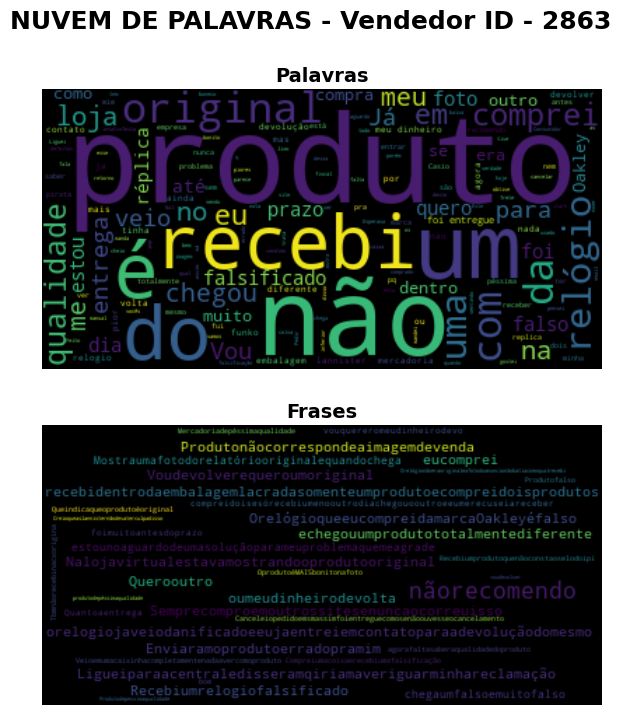

In [62]:
exibir_nuvens("Vendedor ID - 2863", wordcloud, wordcloud_)

**Analisando esses comentários vemos relatos de reclamação dos produtos, com relação a originalidade, qualidade e até envio errado.**

### **Analisando o peso dos dias de atraso em cima das notas**

In [63]:
avaliacoes1.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,atraso,seller_id,product_category_name,seller_id_num
0,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-37.0,15,9,2016,12,1,ecccfa2bb93b34a3bf033cc5d1dcdc69,beleza_saude,1716.0
1,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,2016-10-22 08:25:27,NaN,2016-10-24,NaN,22,10,2016,8,0,NaN,NaN,NaN
2,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-06 20:06:26,2016-10-15 11:00:25,2016-11-28,43.0,6,10,2016,20,0,fedaedd3ca31d56ab33e92035e4b361c,bebes,2956.0


<Axes: xlabel='diferenca_estimativa_e_entrega', ylabel='Count'>

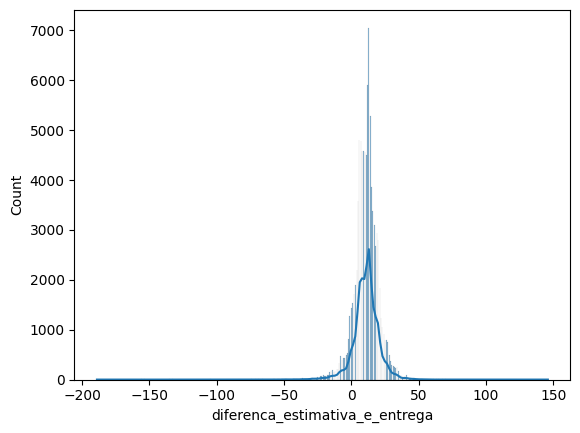

In [64]:
sns.histplot(avaliacoes1.diferenca_estimativa_e_entrega, kde=True)

In [65]:
def dias_entrega(x):
    if x < -20:
        return '01- +20 atraso'
    elif x < -15:
        return "02- (16-20) atraso"
    elif x < -10:
        return "03- (11-15) atraso"
    elif x < -5:
        return "04- (6-10) atraso"
    elif x < 0:
        return "05- (1-5) atraso"
    elif x == 0:
        return "06- Entregue no dia"
    elif x <= 5:
        return "07- (1-5) adiantados"
    elif x <= 10:
        return "08- (6-10) adiantados"
    elif x <= 15:
        return "09- (11-15) adiantados"
    elif x <= 20:
        return "10- (16-20) adiantados"
    elif x > 20:
        return "11- +20 adiantados"

In [66]:
avaliacoes1['Intervalos - Entrega'] = avaliacoes1['diferenca_estimativa_e_entrega'].apply(dias_entrega)

In [67]:
a = avaliacoes1.groupby('Intervalos - Entrega')['review_score'].mean().sort_index()
a

Intervalos - Entrega
01- +20 atraso            1.758007
02- (16-20) atraso        1.656315
03- (11-15) atraso        1.656983
04- (6-10) atraso         1.893398
05- (1-5) atraso          3.462015
06- Entregue no dia       4.161581
07- (1-5) adiantados      4.184415
08- (6-10) adiantados     4.287614
09- (11-15) adiantados    4.334964
10- (16-20) adiantados    4.343464
11- +20 adiantados        4.283506
Name: review_score, dtype: float64

#### **Como podemos ver acima, quanto mais tempo de atraso, menor tende ser a nota.**

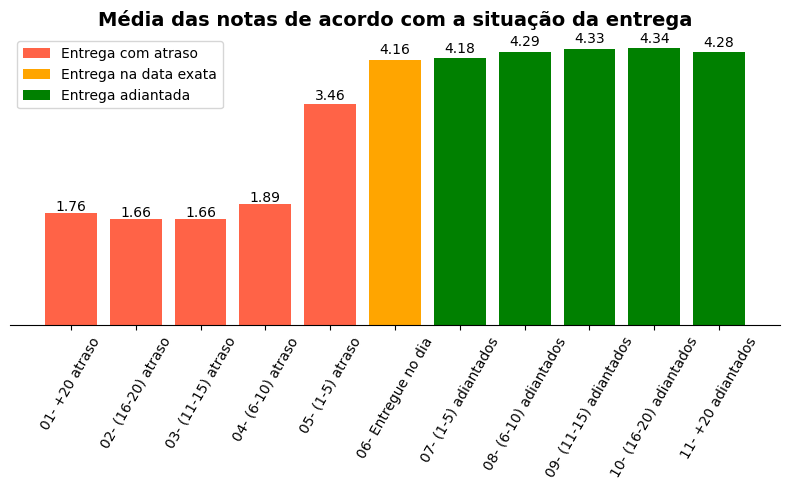

In [68]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
ax.bar(a.index, a.values)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(a.index, rotation=60)
ax.spines[['top','left','right']].set_visible(False)
ax.yaxis.set_visible(False)
for i in range(len(a.index)):
    ax.annotate(round(a.values[i],2),(a.index[i], a.values[i]+a.values[i]*0.02), ha='center')

ax.bar(a.index[:5], a.values[:5], color='tomato',label='Entrega com atraso')
ax.bar(a.index[5], a.values[5], color='orange',label='Entrega na data exata')
ax.bar(a.index[6:], a.values[6:], color='green',label='Entrega adiantada')
ax.legend()
ax.set_title("Média das notas de acordo com a situação da entrega", fontweight='bold', fontsize=14)
plt.savefig("../imagens/media_notas_dias_atraso", transparent=True)
plt.show()

Observando o gráfico acima, podemos notar como o fator de atraso na entrega pode estar afetando a avaliação do usuário. Inclusive, a nota pode ser dada muitas das vezes antes do produto chegar, e mesmo que o produto seja entregue posteriormente e tenha qualidade, o usuário acaba optando por não mudar a avaliação.